In [142]:
from periodictable import elements as pelements

def element_to_atomic_number(element):
    """
    Converts an atomic element symbol to its corresponding atomic number.
    
    Parameters:
        element (str): The chemical symbol of the element (e.g., "H", "He", "Fe").
    
    Returns:
        int: The atomic number of the element, or None if the symbol is invalid.
    """
    try:
        return pelements.symbol(element).number
    except KeyError:
        print(f"Invalid element symbol: {element}")
        return None


def space_group_to_crystal_system(space_group):
    """
    Converts a space group number to its corresponding crystal system (1-7).
    
    Parameters:
        space_group (int): The space group number (1-230).
    
    Returns:
        int: The crystal system as an integer (1-7), or None if the space group is invalid.
    """
    try:
        if 1 <= space_group <= 2:
            return 1  # Triclinic
        elif 3 <= space_group <= 15:
            return 2  # Monoclinic
        elif 16 <= space_group <= 74:
            return 3  # Orthorhombic
        elif 75 <= space_group <= 142:
            return 4  # Tetragonal
        elif 143 <= space_group <= 167:
            return 5  # Trigonal
        elif 168 <= space_group <= 194:
            return 6  # Hexagonal
        elif 195 <= space_group <= 230:
            return 7  # Cubic
        else:
            # print(f"Invalid space group: {space_group}")
            return 0
    except:
        return 0


In [143]:
import numpy as np
import pandas as pd
import torch

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from decifer.decifer_dataset import DeciferDataset
from decifer.decifer_model import Decifer, DeciferConfig
from decifer.tokenizer import Tokenizer
from bin.evaluate import extract_prompt, load_model_from_checkpoint
from decifer.utility import (
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop,
    disc_to_cont_xrd,
    disc_to_cont_xrd_from_cif,
    space_group_symbol_to_number,
    
)

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
tokenizer = Tokenizer()
def collate_fn(batch):
    # batch is a list of dictionaries
    batch_data = {}
    for key in batch[0].keys():
        field_data = [item[key] for item in batch]
        
        if isinstance(field_data[0], torch.Tensor):
            # Pad the sequences to the maximum length in the batch
            padded_seqs = pad_sequence(field_data, batch_first=True, padding_value=tokenizer.padding_id)
            batch_data[key] = padded_seqs
        else:
            batch_data[key] = field_data  # Leave non-tensor fields as-is
    
    return batch_data


# load a cif string and its xrd
dataset = DeciferDataset('../data/crystallm/full/serialized/test.h5', ['cif_string', 'cif_tokenized', 'xrd_disc.q', 'xrd_disc.iq', 'spacegroup', 'species'])
dataloader = DataLoader(dataset, batch_size=32, collate_fn=collate_fn)

In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model_from_checkpoint('../experiments/conditioned_mlp_augmentation/ckpt.pt', device)
model.eval();
cond_embedder = model.transformer.cond_embedding

number of total parameters: 26.14M


In [149]:
embeddings = []
spacegroups = []
avg_elements = []
max_elements = []

debug_max = 1000

pbar = tqdm(total = debug_max)
for i, batch in enumerate(dataloader):
    xrd_disc_q = batch['xrd_disc.q']
    xrd_disc_iq = batch['xrd_disc.iq']
    spgs = [space_group_symbol_to_number(sg) for sg in batch['spacegroup']]
    elements = [[element_to_atomic_number(e) for e in list(e_list.split('"')[1::2])] for e_list in batch['species']]
    avge = [np.mean(e, axis=0) for e in elements]
    maxe = [np.max(e, axis=0) for e in elements]
    
    xrd_out = disc_to_cont_xrd(
        xrd_disc_q,
        xrd_disc_iq,
        qmin = 0.0,
        qmax = 10.0,
        qstep = 0.01,
        fwhm_range = (0.05, 0.05),
        noise_range = None,
        mask_prob=None,
        intensity_scale_range=None
    )
    iq = xrd_out['iq'].to(device=model.device)

    with torch.no_grad():
        embeddings.append(cond_embedder(iq))

    spacegroups.extend(spgs)
    avg_elements.extend(avge)
    max_elements.extend(maxe)

    if i >= debug_max:
        break

    pbar.update(1)
        
embeddings_stacked = torch.vstack(embeddings).cpu().numpy()
spacegroups = np.array(spacegroups, dtype=float)
avg_elements = np.array(avg_elements, dtype=float)
max_elements = np.array(max_elements, dtype=float)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [157]:
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(embeddings_stacked)

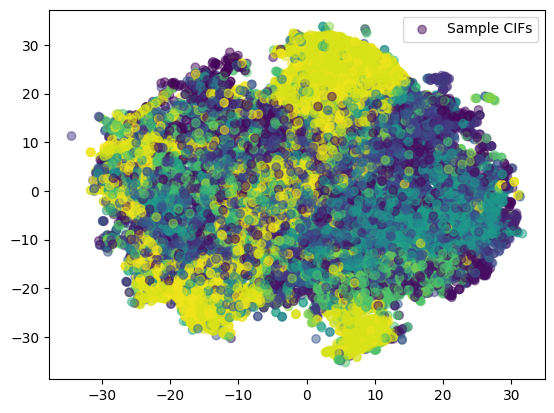

In [158]:
# Plot the TSNE results
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=spacegroups, alpha=0.5, label='Sample CIFs')
plt.legend()
plt.show()

In [167]:
import plotly.express as px
import pandas as pd

# Ensure `spacegroups` is numeric for continuous color mapping
tsne_df = pd.DataFrame({
    'C1': tsne_results[:, 0],
    'C2': tsne_results[:, 1],
    'C3': tsne_results[:, 2],
    'Spacegroup': spacegroups,  # Ensure numeric values
    'AvgElement': avg_elements,
    'MaxElement': max_elements,
    'CrystalSystem': [space_group_to_crystal_system(s) for s in spacegroups],
    'AvgElement+Spacegroup': spacegroups.astype(float) + avg_elements,
})

# Check and convert `spacegroups` to numeric if necessary
if not pd.api.types.is_numeric_dtype(tsne_df['Spacegroup']):
    tsne_df['Spacegroup'] = pd.to_numeric(tsne_df['Spacegroup'], errors='coerce')

# Check and convert `spacegroups` to numeric if necessary
if not pd.api.types.is_numeric_dtype(tsne_df['AvgElement']):
    tsne_df['AvgElement'] = pd.to_numeric(tsne_df['AvgElement'], errors='coerce')

# Check and convert `spacegroups` to numeric if necessary
if not pd.api.types.is_numeric_dtype(tsne_df['MaxElement']):
    tsne_df['MaxElement'] = pd.to_numeric(tsne_df['MaxElement'], errors='coerce')

tsne_df['CrystalSystem'] = tsne_df['CrystalSystem'].astype('category')

# Create the interactive 3D scatter plot with continuous color mapping
fig = px.scatter_3d(
    tsne_df,
    x='C1',
    y='C2',
    z='C3',
    color='CrystalSystem',
    # size ='MaxElement',
    # color_continuous_scale='Viridis',  # Continuous color scale
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title='3D TSNE of Embeddings',
    labels={'Spacegroup': 'Spacegroup'},
    opacity=1.0
)

# Update layout to make the figure larger
fig.update_layout(
    scene=dict(
        xaxis_title='C1',
        yaxis_title='C2',
        zaxis_title='C3'
    ),
    margin=dict(l=20, r=20, t=50, b=20),  # Minimal margins
    width=1000,  # Set figure width
    height=800   # Set figure height
)

# Show the interactive plot
fig.show()


In [168]:
pca = PCA(n_components=3)
pca_results = pca.fit_transform(embeddings_stacked)

In [171]:
import plotly.express as px
import pandas as pd

# Ensure `spacegroups` is numeric for continuous color mapping
pca_df = pd.DataFrame({
    'PC1': pca_results[:, 0],
    'PC2': pca_results[:, 1],
    'PC3': pca_results[:, 2],
    'Spacegroup': spacegroups,  # Ensure numeric values
    'AvgElement': avg_elements,
    'MaxElement': max_elements,
    'CrystalSystem': [space_group_to_crystal_system(s) for s in spacegroups],
    'AvgElement+Spacegroup': spacegroups.astype(float) + avg_elements,
})

# Check and convert `spacegroups` to numeric if necessary
if not pd.api.types.is_numeric_dtype(pca_df['Spacegroup']):
    pca_df['Spacegroup'] = pd.to_numeric(pca_df['Spacegroup'], errors='coerce')

# Check and convert `spacegroups` to numeric if necessary
if not pd.api.types.is_numeric_dtype(pca_df['AvgElement']):
    pca_df['AvgElement'] = pd.to_numeric(pca_df['AvgElement'], errors='coerce')

# Check and convert `spacegroups` to numeric if necessary
if not pd.api.types.is_numeric_dtype(pca_df['MaxElement']):
    pca_df['MaxElement'] = pd.to_numeric(pca_df['MaxElement'], errors='coerce')

pca_df['CrystalSystem'] = pca_df['CrystalSystem'].astype('category')

# Create the interactive 3D scatter plot with continuous color mapping
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='CrystalSystem',
    # size ='MaxElement',
    color_continuous_scale='Viridis',  # Continuous color scale
    title='3D PCA of Embeddings',
    labels={'Spacegroup': 'Spacegroup'},
    opacity=1.0
)

# Update layout to make the figure larger
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=20, r=20, t=50, b=20),  # Minimal margins
    width=1000,  # Set figure width
    height=800   # Set figure height
)

# Show the interactive plot
fig.show()
